0%                          100%
[###                           ]

Strategy DC_20x20, lookback: 20x20, atr_stop 3.0
Strategy DC_50x30, lookback: 50x30, atr_stop 3.0
Strategy DC_100x50, lookback: 100x50, atr_stop 3.0
Strategy DC_200x100, lookback: 200x100, atr_stop 3.0


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:03


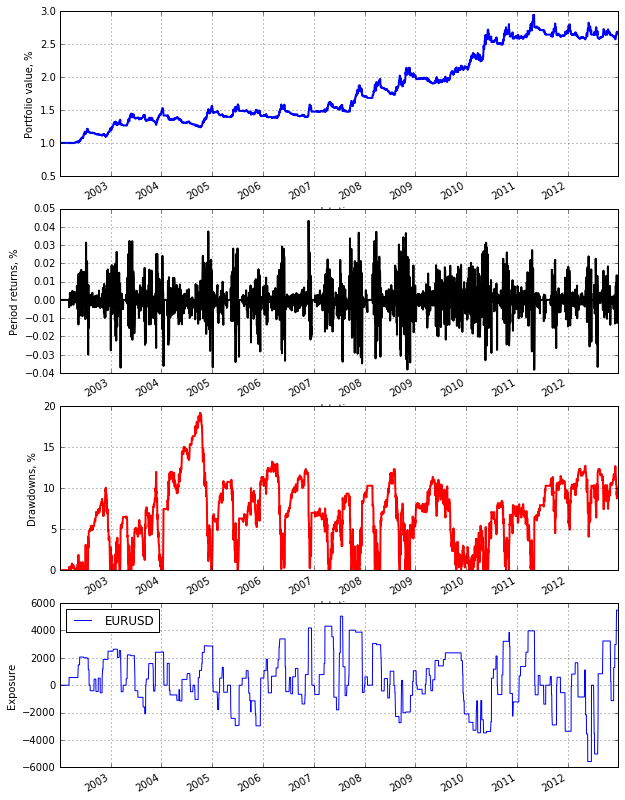

,Base Stats
#Trades,223.000000
CAGR(%),9.340965
Avg trade(R),0.398086
Daily Sharpe,0.704261


In [3]:
import queue
import matplotlib.pyplot as plt
from datetime import datetime

from broker.historical_data_handler import DatabaseDataHandler
from broker.execution_handler import SimulatedExecution
from portfolio import Portfolio
from backtest import BacktestEngine
from broker.account import SimulatedAccount
from strategies.donchian_breakout import DonchianBreakout
from strategies.RSI_MOM_1 import RSI_Trading_Strategy

%matplotlib inline

#PARAMETERS
symbol_list= ['EURUSD']
risk= 0.06
equity = 1000.0
leverage = 20
start_date= datetime(2002,1,1)
end_date= datetime(2012,12,31)


events_queue = queue.Queue()
account = SimulatedAccount(equity,leverage,'USD')
prices = DatabaseDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,db_adress='localhost',
                             timeframe='D1', start_date=start_date,end_date=end_date,data_vendor='FX')
#"""
strategy_1 = DonchianBreakout(prices,events_queue, entry_lookback=20, exit_lookback=20, atr_stop=3.,TP_atr=5.,name='DC_20x20')
strategy_2 = DonchianBreakout(prices,events_queue, entry_lookback=50, exit_lookback=30, atr_stop=3.,TP_atr=5.,name='DC_50x30')
strategy_3 = DonchianBreakout(prices,events_queue, entry_lookback=100, exit_lookback=50, atr_stop=3.,TP_atr=5.,name='DC_100x50')
strategy_4 = DonchianBreakout(prices,events_queue, entry_lookback=200, exit_lookback=100, atr_stop=3.,TP_atr=5.,name='DC_200x100')

#strategy_5 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=30, rsi_trigger_offset=37)
#"""
strategy_6 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=22, rsi_trigger_offset=37)
strategies = [strategy_1,strategy_2,strategy_3,strategy_4,strategy_6]
#strategies=[strategy_6]



portfolio = Portfolio(events_queue=events_queue, prices=prices,account=account,strategies=strategies,risk_per_trade = risk)
portfolio.open_trades.clear()
portfolio.compound=True

execution = SimulatedExecution(events_queue,prices)
backtest = BacktestEngine(events_queue, prices, execution,account, portfolio, strategies)

backtest.backtest_trading()
backtest.stats.plot_performance()
backtest.stats.output_base_stats()

# Backtest Analysis

In [4]:
backtest.stats.output_full_stats()

,All Trades,Long only,Short only
#Trades,223,124,99
CAGR(%),9.34097,NaN,NaN
Avg trade(R),0.398086,0.628328,0.109702
Daily Sharpe,0.704261,NaN,NaN
Max Drawdown(%),19.136,NaN,NaN
Avg Duration,45 days 02:47:53.542600,49 days 12:23:13.548387,39 days 14:32:43.636363
Exposure %,90.7628,51.9944,38.7684
Win Rate %,49.7758,0.580645,0.393939
Avg Win,1.55294,1.6347,1.402
Avg Loss,-0.74646,-0.765116,-0.730291


In [5]:
trades = backtest.stats.trades
trades_per_years = trades.open_date.groupby(trades.open_date.dt.year).count()
ce = backtest.stats.cagr /trades_per_years.mean() *100
print('Cost efficiency %0.2f' %ce)



Cost efficiency 0.46


In [6]:
from scipy import stats
import numpy as np

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

hist = backtest.stats.history
print("R-squared %0.2f" %rsquared(np.arange(len(hist.equity)),hist.equity))

R-squared 0.90


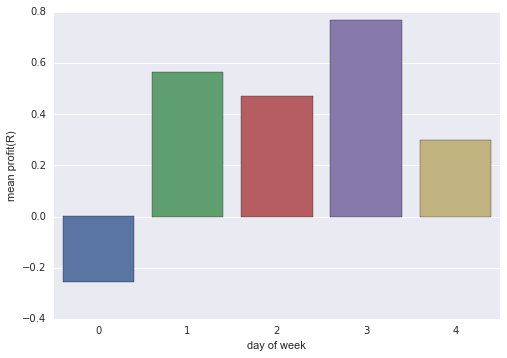

In [8]:
import seaborn as sns
import pandas as pd

df_weekday = trades[['open_date','close_date','profit_R']].reset_index()
df_weekday['open_weekday']=df_weekday.open_date.dt.dayofweek
df_weekday['close_weekday']=df_weekday.close_date.dt.dayofweek
weekday_group = df_weekday.groupby(by='open_weekday')

results = pd.DataFrame(index = weekday_group.profit_R.sum().index)
results['mean'] = weekday_group.profit_R.mean()
sns.barplot(x=results.index,y='mean',data=results)
sns.axlabel(xlabel='day of week',ylabel='mean profit(R)')

# Strategies analysis

In [16]:
strat_equities = pd.DataFrame()
trades['returns'] = trades.profit_R * risk

for strategy in strategies:
    name = strategy.identifier
    equity = (1+trades.profit_R[trades.strategy == name]).cumprod()
    strat_equities = pd.concat([strat_equities,equity],axis=1)
strat_equities.fillna(method='pad',inplace=True)


In [17]:
strat_equities

,profit_R,profit_R,profit_R,profit_R,profit_R
ticket,,,,,
1,5.685300e+00,NaN,NaN,NaN,NaN
2,5.685300e+00,NaN,NaN,NaN,4.363621e+00
3,5.685300e+00,3.645234e+00,NaN,NaN,4.363621e+00
4,5.685300e+00,3.645234e+00,NaN,NaN,1.905419e+01
5,5.685300e+00,3.645234e+00,NaN,NaN,1.428789e+00
6,2.638656e+00,3.645234e+00,NaN,NaN,1.428789e+00
7,2.875038e-01,3.645234e+00,NaN,NaN,1.428789e+00
8,1.120809e-01,3.645234e+00,NaN,NaN,1.428789e+00
9,4.296643e-02,3.645234e+00,NaN,NaN,1.428789e+00
